# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Import Pyomo
from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo

# import constraint Learning Tool
import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code'))
from distcl import distcl

## Load Data

In [ ]:
data = pd.read_csv("data/two_windturbine.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,800,0,8.0,270.0,0.06,1753.954459,615.070589,2369.025048
1,800,200,8.0,270.0,0.06,1753.954459,1751.593411,3505.547870
2,800,400,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
3,800,600,8.0,270.0,0.06,1753.954459,1753.954459,3507.908918
4,900,0,8.0,270.0,0.06,1753.954459,694.023084,2447.977544


# Train NN and generate constraints

In [3]:
### Test/Train Split
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=40, bias=True)
    (1-4): 4 x Linear(in_features=40, out_features=40, bias=True)
  )
  (output_mean_layer): Linear(in_features=40, out_features=1, bias=True)
  (output_sd_layer): Linear(in_features=40, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-4): 5 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 271792.25
epoch 500 loss 16570.66015625
epoch 1000 loss 664.5679321289062
epoch 1500 loss 699.267822265625
epoch 2000 loss 344.8754577636719
epoch 2500 loss 447.0191955566406
epoch 3000 loss 392.718505859375
epoch 3500 loss 243.2452392578125
epoch 4000 loss 525.6220703125
epoch 4500 loss 548.5674438476562
NN fitting process finished with a validation GAUSSIANNLL loss of 150.1251983642578 in epoch 4306


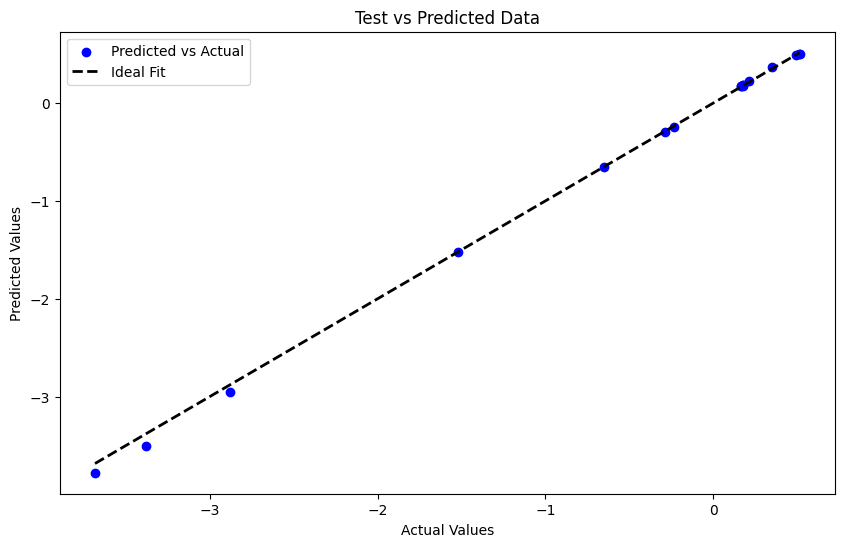

In [ ]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

model, preds_test, sd_test, y_test = cl_tool.train(n_hidden=5, n_nodes=40, iters=5000, drop=0.05, learning_rate=1e-4)

In [ ]:
cons = cl_tool.constraint_build(model)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


In [ ]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

# Define the optimization model
model = ConcreteModel()

# Define decision variables for the x and y coordinates of turbine 2
model.x_turb2 = Var(within=PositiveReals, bounds=(800, 5000))
model.y_turb2 = Var(within=PositiveReals, bounds=(0, 600))

model.objective = Objective(rule=objective_function, sense=minimize)

# Define constraints if any (for example, minimum distance between turbines)
def distance_constraint(model):
    return ((model.x_turb2 - 0)**2 + (model.y_turb2 - 0)**2) >= 400**2  # Example constraint

model.distance_constraint = Constraint(rule=distance_constraint)

cl_tool.const_embed(opt_model=model, constaints=cons, outcome='power', n_scenarios=300)


# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)




NameError: name 'objective_function' is not defined

In [ ]:


# Get the optimized coordinates and farm power
optimized_x_turb2 = value(model.x_turb2)
optimized_y_turb2 = value(model.y_turb2)
turbine_powers, optimized_farm_power = two_turbine_simulation(fmodel, 
                                                              x_turb2=optimized_x_turb2, 
                                                              y_turb2=optimized_y_turb2,
                                                              wind_speeds=wind_speeds, 
                                                              wind_directions=wind_directions, 
                                                              turbulence_intensities=turbulence_intensities)

print(f"Optimized x coordinate of turbine 2: {optimized_x_turb2}")
print(f"Optimized y coordinate of turbine 2: {optimized_y_turb2}")
print(f"Optimized farm power: {optimized_farm_power[0]}")